# LeNet-5论文复现
在这个项目中，我们专注于实现论文的第二部分，该部分描述了在 MNIST 数据集中使用卷积神经网络识别数字的方法。目标是利用卷积层进行特征提取和池化进行降维，以高精度对数字（0-9）进行分类。

## 基本架构
<img src="img/lenet.png">

## 关键特点：
- 卷积神经网络（CNN）架构
- MNIST 数据集上的手写数字分类应用
- 所需预处理最少，专注于原始像素数据

## 步骤：
- 加载和预处理数据：MNIST 数据集已预处理并归一化，用于训练 CNN。
- CNN 架构：该模型由卷积层、激活函数和池化层组成，用于从图像中提取相关特征。
- 训练：该模型使用基于梯度的学习技术进行训练。（PyTorch实现）
- 评估：在测试数据上评估训练好的模型以评估其性能。

### 1. 必要库的导入

In [1]:
import os
import sys
import torch
from torch import optim, nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
from PIL import Image
# 获取当前文件的父目录
parent_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'),'..'))
# 如果父目录不在 sys.path中，则添加
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils
import utils
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available()
                      else 'mps' if torch.mps.is_available()
                      else 'cpu')

### 2. 导入数据库并转换为DataLoader格式

In [ ]:
# 加载数据集并把图片转化为张量格式
transform = {'train':transforms.Compose([
                     transforms.Grayscale(num_output_channels=1),
                     transforms.Resize((32, 32)),
                     transforms.RandomHorizontalFlip(),
                     transforms.RandomAffine(degrees=7,
                                             translate=(0,0.07),
                                             shear=7,
                                             scale=(1,1.2)),
                     transforms.ToTensor()]),
             'test':transforms.Compose([
                    transforms.Grayscale(num_output_channels=1),
                    transforms.Resize((32,32)),
                    transforms.ToTensor()])
    }


# mnist_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
# mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
# 由于文件夹中已经有了mnist数据集，因此我们把download改为False即可
mnist_train = datasets.MNIST(root='../Datasets/MNIST', train=True, download=False, transform=transform['train'])
mnist_test = datasets.MNIST(root='../Datasets/MNIST', train=False, download=False, transform=transform['test'])

In [4]:
# 把数据集转换为DataLoader使其可迭代
batch_size = 128
num_workers = 4
mnist_train_iter = DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=num_workers)
mnist_test_iter = DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=num_workers)

In [5]:
# 打印第一张图片的张量出来看看
img = next(iter(mnist_train_iter)) 
'''此处返回的是一个列表,一共有两个元素,
第一个元素是一个四维张量,形状为(128,1,28,28),代表一个batch的所有图像的张量
第二个元素是一个一维张量,形状为[128],代表一个batch中所有图像的标签'''
print(len(img))
print(img[0].shape)
print(img[1].shape)
print(img[0][0]) # 返回第一张图片的张量
print(img[1][0]) # 返回第一张图片代表的数字

2
torch.Size([128, 1, 32, 32])
torch.Size([128])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(3)


### 3. 定义神经网络模型

卷积层的各个参数含义:
```python
Conv2d(input_channel,output_channel,kernel_size,stride,padding)
```

需要注意的是卷积层后怎样计算图形的像素:

$$
\text{Output Size} = \left\lfloor \frac{W_{\text{in}} - K + 2 \times P}{S} \right\rfloor + 1
$$

#### 参数说明
- **$W_{\text{in}}$**: 输入图片的宽或高
- **$K$**: 卷积核的宽或高
- **$P$**: 特征图片四周的填充像素个数
- **$S$**: 卷积核的步长
- **$\text{Output Size}$**: 输出图片的宽或高

#### 举例
假设输入特征图尺寸为 $32 \times 32$，卷积核尺寸为 $5 \times 5$，填充为 2，步幅为 1，则输出特征图尺寸为：
$$
\text{Output Size} = \left\lfloor \frac{32 - 5 + 2 \times 2}{1} \right\rfloor + 1 = 32
$$

In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # 输入通道，输出通道，卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 池化核大小，步长
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16,120,5),
            nn.ReLU()
        )
        self.fc = nn.Sequential(
            nn.Flatten(), # 将一个四维向量转变为二维向量，其中第一维是batch，第二维是Channel*Width*Height
            nn.Linear(120, 84), # 经过计算，图的像素变为1，因此通道数*像素数=120
            nn.ReLU(),
            nn.Linear(84, 10) # 最终一共有10个类别，因此输出为10
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature)
        return output

In [3]:
net = LeNet().to(device)
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)


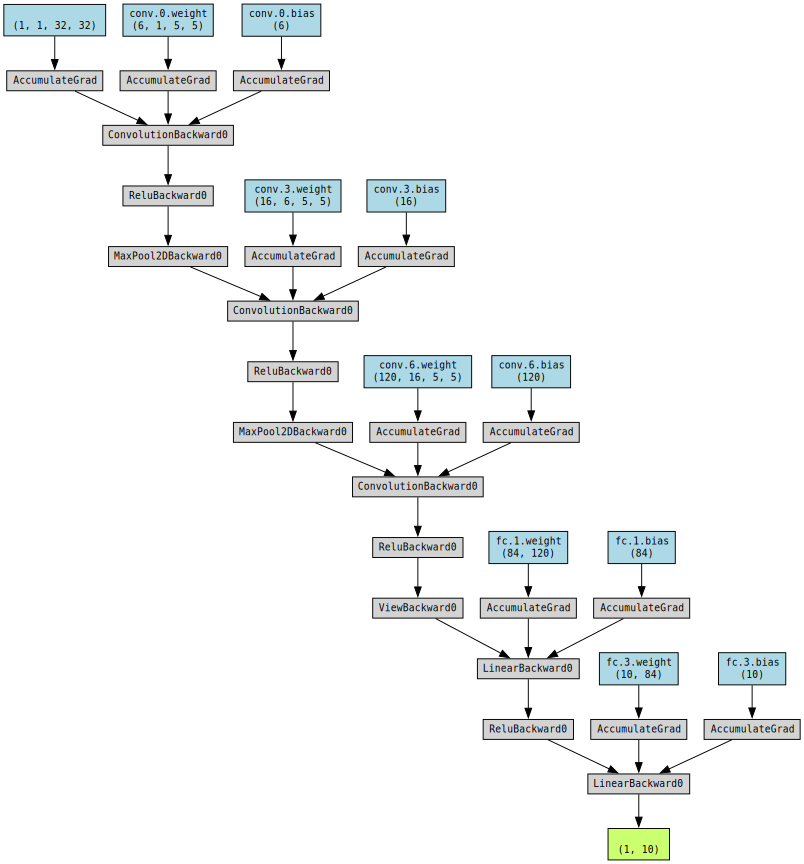

In [4]:
from torchviz import make_dot
import os
os.environ["PATH"] += os.pathsep + '/opt/homebrew/bin'  # M1/M2 Mac

x = torch.rand(1, 1, 32, 32).to(device).requires_grad_(True)
model = net.to(device)
y = model(x)
MyConvNetVis = make_dot(y, params=dict(model.named_parameters()))
MyConvNetVis.format = "png"
MyConvNetVis.render("LeNet", format="png")
MyConvNetVis

### 4. 定义损失函数、优化器

In [8]:
loss_fn = nn.CrossEntropyLoss() # 这里是多种分类，因此采用CrossEntropyLoss
optimizer = optim.Adam(params=net.parameters(),lr=0.001)

### 5. 开始训练

In [9]:
def train(net,train_iter,test_iter,optimizer,loss_fn,device,num_epochs):
    net = net.to(device)
    print('Training on: ', device)

    if loss_fn == None:
        loss_fn = nn.CrossEntropyLoss()
    
    if optimizer == None:
        optimizer = optim.Adam(params=net.parameters(),lr=0.001)
    
    for epoch in range(num_epochs):
        net.train()
        y_true_train, y_pred_train = [],[]
        for X_train,y_train in train_iter:
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            y_pred_logit_train = net(X_train)
            y_pred_label_train = torch.argmax(torch.softmax(y_pred_logit_train,dim=1),dim=1)
            y_true_train.extend(y_train.cpu().numpy())
            y_pred_train.extend(y_pred_label_train.cpu().numpy())
            
            loss = loss_fn(y_pred_logit_train,y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_acc = accuracy_score(y_true_train,y_pred_train)
            
        net.eval()
        with torch.inference_mode():
            y_true_test, y_pred_test = [], []
            for X_test,y_test in test_iter:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                y_pred_label_test = torch.argmax(torch.softmax(net(X_test),dim=1),dim=1)
                y_true_test.extend(y_test.cpu().numpy())
                y_pred_test.extend(y_pred_label_test.cpu().numpy())
            test_acc = accuracy_score(y_true_test,y_pred_test)
        if epoch % 1 == 0:
            print(f"epoch {epoch+1} | Train Accuracy {train_acc:.4f} | Test Accuracy {test_acc:.4f}")

In [9]:
# train(net,mnist_train_iter,mnist_test_iter,optimizer,loss_fn,device,num_epochs=4)

### 6. 你也可以使用utils.py中的模块

Training and Testing on mps
Epoch1 | Train Loss: 0.7693 | Train Accuracy: 73.91%
       | Test Loss:  0.2704 | Test Accuracy: 92.05%
Epoch2 | Train Loss: 0.2951 | Train Accuracy: 90.63%
       | Test Loss:  0.2062 | Test Accuracy: 93.45%
Epoch3 | Train Loss: 0.2005 | Train Accuracy: 93.70%
       | Test Loss:  0.1166 | Test Accuracy: 96.25%
Epoch4 | Train Loss: 0.1551 | Train Accuracy: 95.22%
       | Test Loss:  0.0944 | Test Accuracy: 96.98%
Epoch5 | Train Loss: 0.1291 | Train Accuracy: 95.96%
       | Test Loss:  0.0844 | Test Accuracy: 97.41%
Epoch6 | Train Loss: 0.1127 | Train Accuracy: 96.48%
       | Test Loss:  0.0710 | Test Accuracy: 97.72%
Epoch7 | Train Loss: 0.1028 | Train Accuracy: 96.78%
       | Test Loss:  0.0572 | Test Accuracy: 98.16%
Epoch8 | Train Loss: 0.0920 | Train Accuracy: 97.08%
       | Test Loss:  0.0572 | Test Accuracy: 98.10%
Epoch9 | Train Loss: 0.0879 | Train Accuracy: 97.25%
       | Test Loss:  0.0564 | Test Accuracy: 98.06%
Epoch10 | Train Loss: 0.082

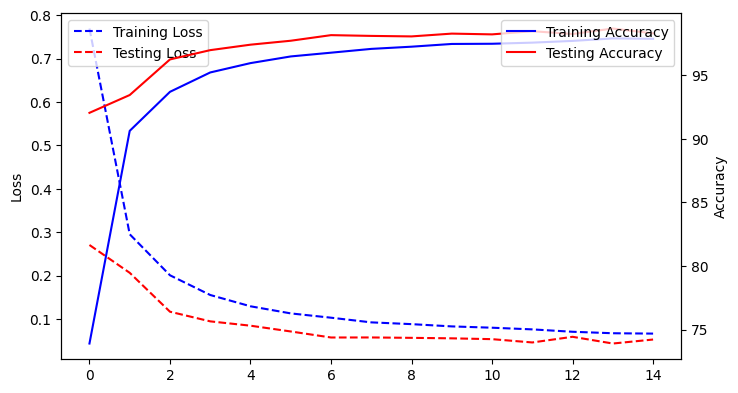

In [10]:
utils.training_loop(model=net,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    train_iter=mnist_train_iter,
                    test_iter=mnist_test_iter, 
                    epochs=15,
                    device = device)